In [1]:
## Exercise 2
# 1 Comment on your solution to exercise 1b
# 2 Comment on others' solution to Exercise 1b


In [2]:
# 3 Data Preparation

import numpy as np
from sklearn.datasets import load_digits
from sklearn import model_selection


In [3]:
digits = load_digits()
print(digits.keys())
data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]
X_sub = data[ (target== 1)|(target== 7) , : ]
Y_sub = target[ (target== 1)|(target== 7) ]


dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


In [5]:
# Check the number of instances, and should be 361.

np.shape(X_sub)
np.shape(Y_sub)


(361,)

In [6]:
# 3.1 Dimension Reduction (4 points)
# f1: mean of pixel region around image[4:8,1:3] (row 5 to 8, column 2 to 4)
# f2: mean of pixel region aroung image[0:6,6]  (row 1 to 5, column 6)

def reduce_dim(x):
    xR = np.array([]).reshape(0,2)
    for i in range(len(x)):
        f1 = np.mean(x[i,:].reshape(8,8)[4:8,1:4])
        f2 = np.mean(x[i,:].reshape(8,8)[0:5,6])
        xR = np.append(xR, [[f1,f2]], axis=0)
    return xR


In [7]:
reduced_x = reduce_dim(X_sub)
np.shape(X_sub)
np.shape(reduced_x)


(361, 2)

In [8]:
# Split the filtered dataset into train set and test set (#train/#test = 3/2)

X_train , X_test , Y_train , Y_test = model_selection.train_test_split(reduced_x, Y_sub,test_size = 0.4, random_state = 0)


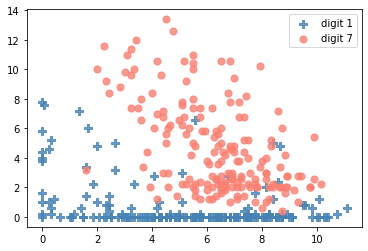

In [9]:
# 3.2 Scatterplot (4 points)

import matplotlib.pyplot as plt
plt.scatter(x=reduced_x[Y_sub == 1,0],y=reduced_x[Y_sub == 1,1], marker="P", color='steelblue',alpha=0.8,s=50,label="digit 1")
plt.scatter(x=reduced_x[Y_sub == 7,0],y=reduced_x[Y_sub == 7,1], marker="o", color='salmon',alpha=0.8,s=50,label="digit 7")
plt.legend()
plt.show()


In [10]:
# 4 Nearest Mean
# 4.1 Implement the nearest mean classifier (3 points)

def nearest_mean(training_features, training_labels, test_features):
    TL = [tl for tl in set(training_labels)]    # ==1,==7 
    TF = np.array([np.mean(training_features[training_labels==tl, : ], axis=0) for tl in TL])  # ==1,==7  ,  (2,2)
    distm =  np.linalg.norm(TF[ : , np.newaxis] - test_features, axis = 2)
    disti = np.argpartition(distm, kth = 1, axis = 0)[ :1 , : ]
    distv = np.array(TL)[disti]
    test_labels = np.array([ np.bincount(distv[ : , v ]).argmax() for v in range(len(distv[0])) ])
    return test_labels


In [11]:
predicted_labels = nearest_mean(training_features=X_train, training_labels=Y_train, test_features=X_test)


In [12]:
# 4.2 Visualize the decision regions (4 points)

def plotDecisionRegions(x,y):
    x1_min, x1_max = x[:, 0].min() - 0.5, x[:,0].max() + 0.5
    x2_min, x2_max = x[:, 1].min() - 0.5, x[:,1].max() + 0.5
    xx1, xx2= np.meshgrid (np.arange(x1_min, x1_max,step= (x1_max-x1_min)/200), np.arange(x2_min, x2_max,step=(x2_max-x2_min)/200))
    Z = nearest_mean(training_features=x, training_labels=y, test_features=np.c_[xx1.ravel(), xx2.ravel()])
    Z = Z.reshape(xx1.shape)
    TL = [tl for tl in set(y)]    # ==1,==7 
    TF = np.array([np.mean(x[y==tl, : ], axis=0) for tl in TL])
    #plt.figure()
    plt.contour(xx1, xx2, Z, cmap=plt.cm.Paired, alpha= 0.3)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    mk = [m for m in range(4,12)]
    for i in range(len(TL)):
        rgb = np.random.rand(3,)
        plt.scatter(x=TF[TL == TL[i],0],y=TF[TL == TL[i],1], marker=mk[i], color=rgb,alpha=0.9,s=250,label=("Mean Y==" + str(TL[i])))
    pass


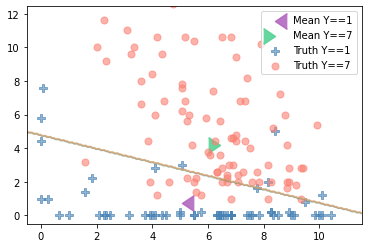

In [18]:
plotDecisionRegions(x=X_train,y=Y_train)
plt.scatter(x=X_test[Y_test == 1,0],y=X_test[Y_test == 1,1], marker="P", color='steelblue',alpha=0.6,s=50,label="Truth Y==1")
plt.scatter(x=X_test[Y_test == 7,0],y=X_test[Y_test == 7,1], marker="o", color='salmon',alpha=0.6,s=50,label="Truth Y==7")
plt.legend()
plt.show()


In [19]:
# 5 QDA
# 5.1 Implement QDA Training (6 points)

def fit_qda(training_features, training_labels):
    training_labels = (training_labels == list(set(training_labels))[0]).__invert__().astype(int)
    TL = set(training_labels)   # [1,7]
    p = [len(training_features[training_labels==tl,:])/len(training_features) for tl in TL]
    mu = np.array([np.mean(training_features[training_labels==tl, : ], axis=0) for tl in TL])  # ==1,==7  ,  (2,2)
    covmat = np.array([np.cov(training_features[training_labels == tl,:].T) for tl in TL])
    return mu, covmat, p


In [20]:
mu, covmat, p = fit_qda(training_features=X_train, training_labels=Y_train)


In [22]:
# 5.2 Implement QDA Prediction (3 points)

def predict_qda(mu, covmat, p, test_features):
    TF = test_features
    #ps = np.array([]).reshape(len(TF),2)
    ps = []
    for i in range(len(TF)):  # number of sample
        for k in range(len(p)):   # number of class
            d = TF[i, :] - mu[k,:]   # diff of means
            M = (-1/2) * np.dot( np.dot(d.T, np.linalg.inv(covmat[k,:,:])), d)    # Mahalanobis Distance
            g = 1 / np.sqrt((2 * np.pi ** mu.shape[1]) * np.linalg.det(covmat[k,:,:]))    # terms before exp
            pp = g * np.e ** M  # Concatenate all the terms
            ps = np.append(ps, pp)
    ps = np.array(ps).reshape(len(TF),TF.shape[1])
    test_labels = np.argmax(ps, axis=1)
    return test_labels

def calQDAerror(true_labels,predicted_labels):
    errorA = []
    true_labels = (true_labels == list(set(true_labels))[0]).__invert__().astype(int)
    N_test = len(true_labels)
    err = (N_test - np.sum(predicted_labels == true_labels)) / N_test
    errorA.append( err )
    return errorA


In [23]:
predicted_test_labels = predict_qda(mu=mu, covmat=covmat, p=p, test_features=X_test)
predicted_train_labels = predict_qda(mu=mu, covmat=covmat, p=p, test_features=X_train)


In [24]:
calQDAerror(true_labels=Y_train,predicted_labels=predicted_train_labels)


[0.1111111111111111]

In [25]:
calQDAerror(true_labels=Y_test,predicted_labels=predicted_test_labels)


[0.10344827586206896]

In [26]:
# 5.3 Visualization (5 points)


In [29]:
# 5.4 Performance evaluation (3 points)

from sklearn.model_selection import KFold

def evaluateQDA(X,Y,k):
    cv = KFold(n_splits=k, shuffle=True)
    for train_ind, test_ind in cv.split(Y):
        X_train, Y_train = X[train_ind,:], Y_sub[train_ind,]
        X_test, Y_test = X[test_ind,:], Y_sub[test_ind,]
        #print(np.take(Y_sub,train_index), np.take(Y_sub,test_index))
        mu, covmat, p = fit_qda(training_features=X_train, training_labels=Y_train)
        predicted_test_labels = predict_qda(mu=mu, covmat=covmat, p=p, test_features=X_test)
        predicted_train_labels = predict_qda(mu=mu, covmat=covmat, p=p, test_features=X_train)  
        errA = calQDAerror(true_labels=Y_train,predicted_labels=predicted_train_labels)
        errB = calQDAerror(true_labels=Y_test,predicted_labels=predicted_test_labels)
        print(errA,errB)


In [30]:
evaluateQDA(X=reduced_x,Y=Y_sub,k=10)


[0.13580246913580246] [0.13513513513513514]
[0.12923076923076923] [0.16666666666666666]
[0.13230769230769232] [0.1111111111111111]
[0.13538461538461538] [0.1388888888888889]
[0.13846153846153847] [0.08333333333333333]
[0.12923076923076923] [0.16666666666666666]
[0.13846153846153847] [0.1111111111111111]
[0.11384615384615385] [0.2222222222222222]
[0.13230769230769232] [0.08333333333333333]
[0.14153846153846153] [0.05555555555555555]


In [31]:
# 6 LDA (8 points)
# 6.1 Implement LDA Training (6 points)

def fit_lda(training_features, training_labels):
    training_labels = (training_labels == list(set(training_labels))[0]).__invert__().astype(int)
    TL = set(training_labels)   # [1,7]
    p = [len(training_features[training_labels==tl,:])/len(training_features) for tl in TL]
    mu = np.array([np.mean(training_features[training_labels==tl, : ], axis=0) for tl in TL])  # ==1,==7  ,  (2,2)
    covmat = np.cov(training_features.T)
    return mu, covmat, p


In [32]:
mu, covmat, p = fit_lda(training_features=X_train, training_labels=Y_train)


In [33]:
# 6.2 Implement LDA Prediction (3 points)

def predict_lda(mu, covmat, p, test_features):
    TF = test_features
    #ps = np.array([]).reshape(len(TF),2)
    ps = []
    for i in range(len(TF)):  # number of sample
        for k in range(len(p)):   # number of class
            d = TF[i, :] - mu[k,:]   # diff of means
            M = (-1/2) * np.dot( np.dot(d.T, np.linalg.inv(covmat[:,:])), d)    # Mahalanobis Distance
            g = 1 / np.sqrt((2 * np.pi ** mu.shape[1]) * np.linalg.det(covmat[:,:]))    # terms before exp
            pp = g * np.e ** M  # Concatenate all the terms
            ps = np.append(ps, pp)
    ps = np.array(ps).reshape(len(TF),TF.shape[1])
    test_labels = np.argmax(ps, axis=1)
    return test_labels

def calLDAerror(true_labels,predicted_labels):
    errorA = []
    true_labels = (true_labels == list(set(true_labels))[0]).__invert__().astype(int)
    N_test = len(true_labels)
    err = (N_test - np.sum(predicted_labels == true_labels)) / N_test
    errorA.append( err )
    return errorA


In [34]:
predicted_train_labels = predict_lda(mu=mu, covmat=covmat, p=p, test_features=X_train)
predicted_test_labels = predict_lda(mu=mu, covmat=covmat, p=p, test_features=X_test)


In [37]:
calLDAerror(true_labels=Y_train,predicted_labels=predicted_train_labels)


[0.18055555555555555]

In [38]:
calLDAerror(true_labels=Y_test,predicted_labels=predicted_test_labels)


[0.15172413793103448]

In [39]:
# 6.3 Visualization (5 points)


In [41]:
# 6.4 Performance evaluation (3 points)

from sklearn.model_selection import KFold

def evaluateLDA(X,Y,k):
    cv = KFold(n_splits=k, shuffle=True)
    for train_ind, test_ind in cv.split(Y):
        X_train, Y_train = X[train_ind,:], Y_sub[train_ind,]
        X_test, Y_test = X[test_ind,:], Y_sub[test_ind,]
        #print(np.take(Y_sub,train_index), np.take(Y_sub,test_index))
        mu, covmat, p = fit_lda(training_features=X_train, training_labels=Y_train)
        predicted_test_labels = predict_lda(mu=mu, covmat=covmat, p=p, test_features=X_test)
        predicted_train_labels = predict_lda(mu=mu, covmat=covmat, p=p, test_features=X_train)  
        errA = calLDAerror(true_labels=Y_train,predicted_labels=predicted_train_labels)
        errB = calLDAerror(true_labels=Y_test,predicted_labels=predicted_test_labels)
        print(errA,errB)


In [42]:
evaluateLDA(X=reduced_x,Y=Y_sub,k=10)


[0.16666666666666666] [0.1891891891891892]
[0.16923076923076924] [0.19444444444444445]
[0.16307692307692306] [0.19444444444444445]
[0.16615384615384615] [0.1388888888888889]
[0.16307692307692306] [0.2222222222222222]
[0.1753846153846154] [0.08333333333333333]
[0.16615384615384615] [0.19444444444444445]
[0.16615384615384615] [0.19444444444444445]
[0.16615384615384615] [0.16666666666666666]
[0.1753846153846154] [0.08333333333333333]
